<a href="https://colab.research.google.com/github/tnwls6865/Creative_Masters/blob/main/week11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers==0.8.0 transformers ftfy
!pip install -qq "ipywidgets>=7,<8"
!pip install -q -UU gradio
!git lfs install
!git clone https://github.com/timojl/clipseg 
!pip install git+https://github.com/openai/CLIP.git -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.2 MB/s eta 0:00:00


In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
%cd clipseg

/content/clipseg


In [5]:
import torch
import requests
import cv2 
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

from io import BytesIO
from torch import autocast
import requests
import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline as StableDiffusionInpaintPipeline

In [6]:
!wget https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download -O weights.zip
!unzip -d weights -j weights.zip

--2023-05-19 11:37:40--  https://owncloud.gwdg.de/index.php/s/ioHbRzFx6th32hn/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘weights.zip’

weights.zip             [           <=>      ]   9.68M  4.56MB/s    in 2.1s    

2023-05-19 11:37:44 (4.56 MB/s) - ‘weights.zip’ saved [10146905]

Archive:  weights.zip
 extracting: weights/rd16-uni.pth    
 extracting: weights/rd64-uni-refined.pth  
 extracting: weights/rd64-uni.pth    


In [7]:
# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval()

# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load('/content/clipseg/weights/rd64-uni.pth', map_location=torch.device('cuda')), strict=False);

100%|████████████████████████████████████████| 335M/335M [00:01<00:00, 238MiB/s]


In [8]:
device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [9]:
# or load from URL...
image_url = 'https://okmagazine.ge/wp-content/uploads/2021/04/00-promo-rob-pattison-1024x1024.jpg' #'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimage.tmdb.org%2Ft%2Fp%2Foriginal%2F72xYNWRTVMDiKVa6SVu6EY0S9Np.jpg' #'https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png' 
input_image = Image.open(requests.get(image_url, stream=True).raw)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((512, 512)),
])
img = transform(input_image).unsqueeze(0)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [10]:
input_image.convert("RGB").resize((512, 512)).save("init_image.png", "PNG")

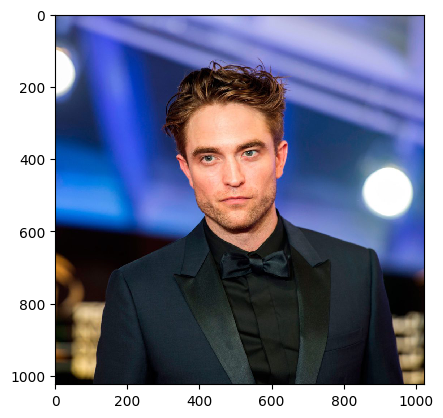

In [11]:
from matplotlib import pyplot as plt
plt.imshow(input_image, interpolation='nearest')
plt.show()

In [12]:
prompts = ['shirt']

In [13]:
# predict
with torch.no_grad():
    preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]

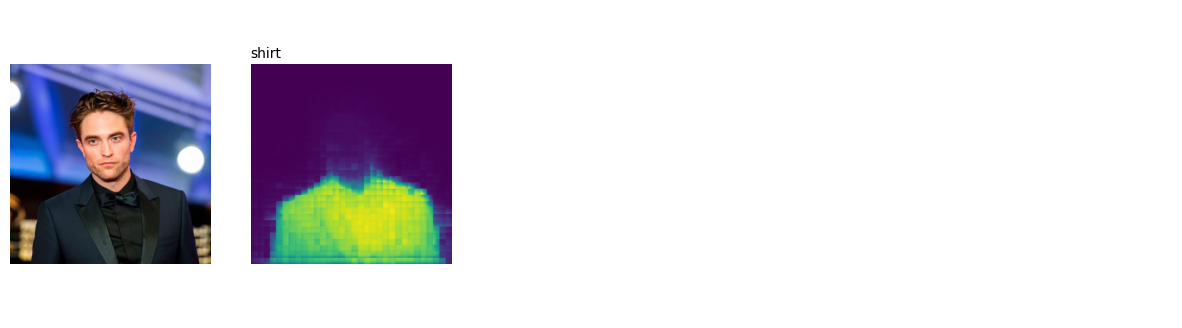

In [14]:
# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];

In [15]:
filename = f"mask.png"
plt.imsave(filename,torch.sigmoid(preds[0][0]))

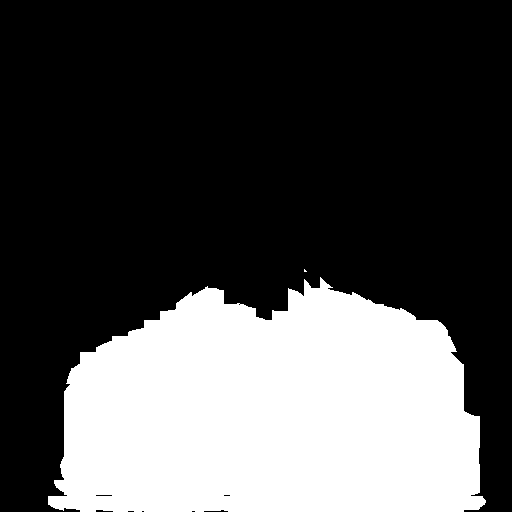

In [16]:
img2 = cv2.imread(filename)

gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# For debugging only:
cv2.imwrite(filename,bw_image)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)

In [17]:
init_image = Image.open('init_image.png')
mask = Image.open('mask.png')

In [18]:
with autocast("cuda"):
    images = pipe(prompt="a yellow flowered holiday shirt", init_image=init_image, mask_image=mask, strength=0.8)

  0%|          | 0/41 [00:00<?, ?it/s]

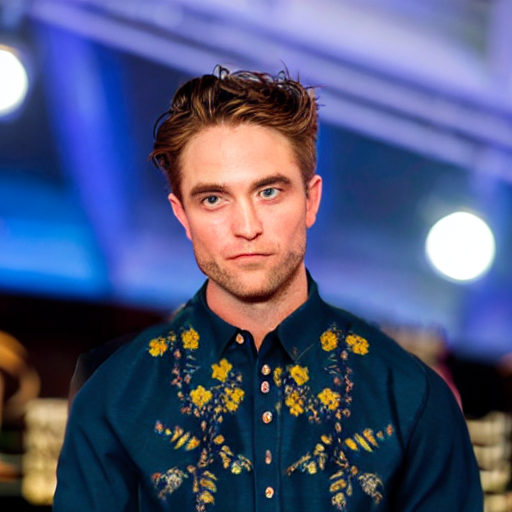

In [19]:
images['images'][0]

In [21]:
!pip install diffusers==0.11.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 30.4 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.8.0
    Uninstalling diffusers-0.8.0:
      Successfully uninstalled diffusers-0.8.0


In [1]:
import requests
from PIL import Image
from io import BytesIO
from diffusers import StableDiffusionUpscalePipeline
import torch

# load model and scheduler
model_id = "stabilityai/stable-diffusion-x4-upscaler"
pipeline = StableDiffusionUpscalePipeline.from_pretrained(
    model_id, revision="fp16", torch_dtype=torch.float16
)
pipeline = pipeline.to("cuda")

# let's download an  image
url = "https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd2-upscale/low_res_cat.png"
response = requests.get(url)
low_res_img = Image.open(BytesIO(response.content)).convert("RGB")
low_res_img = low_res_img.resize((128, 128))
prompt = "a white cat"

upscaled_image = pipeline(prompt=prompt, image=low_res_img).images[0]
upscaled_image.save("upsampled_cat.png")

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


  0%|          | 0/75 [00:00<?, ?it/s]

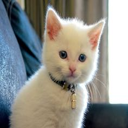

In [3]:
low_res_img

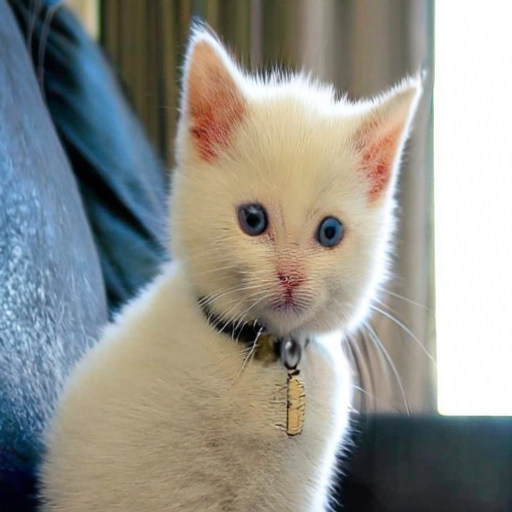

In [2]:
Image.open("/content/upsampled_cat.png")

In [4]:
import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline

In [5]:
device = "cuda"
model_path = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
)
pipe = pipe.to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


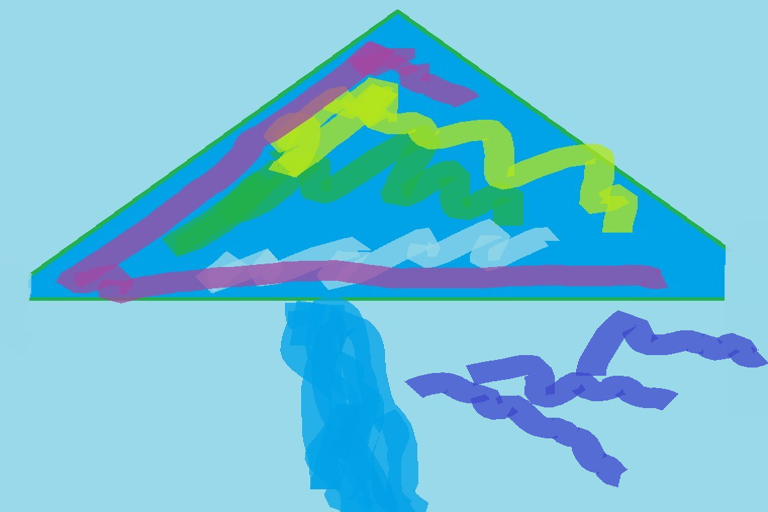

In [6]:
import requests
from io import BytesIO
from PIL import Image

# url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

# response = requests.get(url)
init_img = Image.open('/content/testing2.jpg').convert("RGB")
init_img = init_img.resize((768, 512))
init_img

In [7]:
generator = torch.Generator(device=device).manual_seed(42)
with autocast("cuda"):
    image = pipe(prompt="", init_image=init_img, strength=0.8, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/40 [00:00<?, ?it/s]

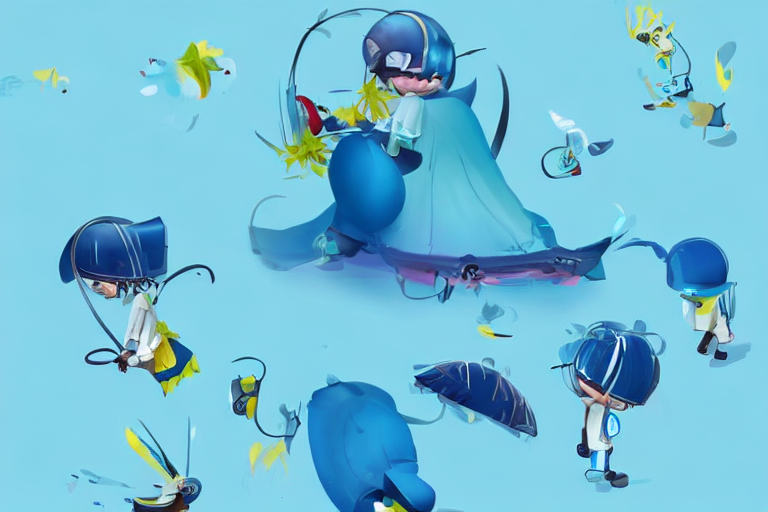

In [8]:
image

In [9]:
generator = torch.Generator(device=device).manual_seed(42)
with autocast("cuda"):
    image = pipe(prompt="A fantasy landscape, trending on artstation", init_image=init_img, strength=0.8, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/40 [00:00<?, ?it/s]

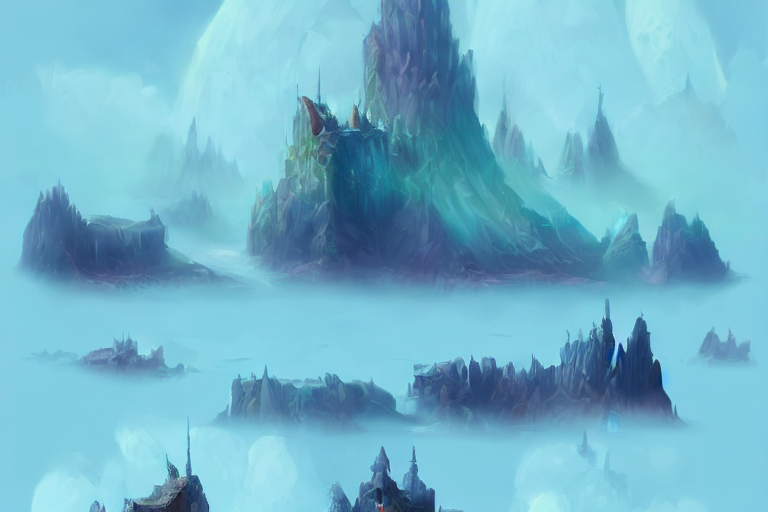

In [10]:
image